# Imports

In [28]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import box, mapping
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


# Constants

In [2]:
# Panama
shape_path = "data/Panama/panama_rect.shx"

list_unmerged_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
s2_merged_path_no_process = "data/Panama/S2_merged_20211210.tif"
s2_merged_path_process = 'data/Panama/S2_merged_20211210_reproj.tif'

s1_path_no_process = "data/Panama/S1_inter_20220128_20220209.geo.unw.tif"
s1_path_process = 'data/Panama/S1_inter_20220128_20220209_reproj.geo.unw.tif'

capella_path_no_process = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"

iceye_path_no_process = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
iceye_path_process = 'data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC_reproj.tif'

FIRST_LOCATION_RUN = False
WANTED_RES = 0.00018 # approx 20 meters

# Data preprocessing

## Once per location

In [3]:
def find_largest_rectangle_geometry(polygon, steps=30, aspect_ratio=1.1):
    minx, miny, maxx, maxy = polygon.bounds
    best_rect = None
    best_area = 0

    x_vals = np.linspace(minx, maxx, steps)
    y_vals = np.linspace(miny, maxy, steps)

    for cx in x_vals:
        for cy in y_vals:
            # Binary search on width (since height = width * aspect_ratio)
            low, high = 0, min(maxx - minx, maxy - miny)
            while high - low > 1e-2:
                w = (low + high) / 2
                h = w * aspect_ratio  # enforce vertical orientation
                candidate = box(cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2)
                if polygon.contains(candidate):
                    low = w
                    area = w * h
                    if area > best_area:
                        best_area = area
                        best_rect = candidate
                else:
                    high = w
    return best_rect

In [4]:
def merge_rasters(list_of_files, output_path):
    # Open the two datasets
    src_files_to_mosaic = []
    for fp in list_of_files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge them
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Get metadata from one of the input files
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0]  # Number of bands
    })

    # Output path
    output_path = 'data/Panama/S2_merged_20211210.tif'

    # Write to disk
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    print(f"Merged file saved to {output_path}")

In [5]:
def reproject_and_clip_raster(raster_path, geometry_gdf, output_path):
    # Read input raster
    with rasterio.open(raster_path) as src:
        # Get target CRS from geometry
        target_crs = geometry_gdf.crs
        
        # Calculate transform and dimensions for new resolution and CRS
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds, resolution=WANTED_RES
        )

        # Create destination array and metadata
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open('temp_reprojected.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

    # Clip the reprojected raster to the geometry
    with rasterio.open('temp_reprojected.tif') as src:
        geoms = [mapping(geom) for geom in geometry_gdf.geometry]
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Save final clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

## Shapefile

In [6]:
def get_aoi_geometry(file_path, need_resizing=False, save_to=''):
    if not need_resizing:
        aoi = gpd.read_file(file_path)['geometry']
    else:
        aoi = gpd.read_file(file_path)['geometry']
        aoi = gpd.GeoSeries([find_largest_rectangle_geometry(aoi[0])])
        aoi.to_file(save_to)
    return aoi

In [7]:
aoi = get_aoi_geometry(shape_path, FIRST_LOCATION_RUN)
aoi = aoi.set_crs("EPSG:4326", allow_override=True)

## Functions

In [8]:
def open_tif_file(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        profile = src.profile
    return image, profile

In [9]:
def min_max_normalize(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

## Optical

In [10]:
def compute_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-6)

def compute_evi(nir, red, blue):
    return 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)

def compute_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-6)

def compute_brightness(blue, green, red):
    return (blue + green + red) / 3
## potentially add more vegetation indicies

### Sentinel 2

Sentinel 2 optical data:
- Compute desired VIs and BPVs

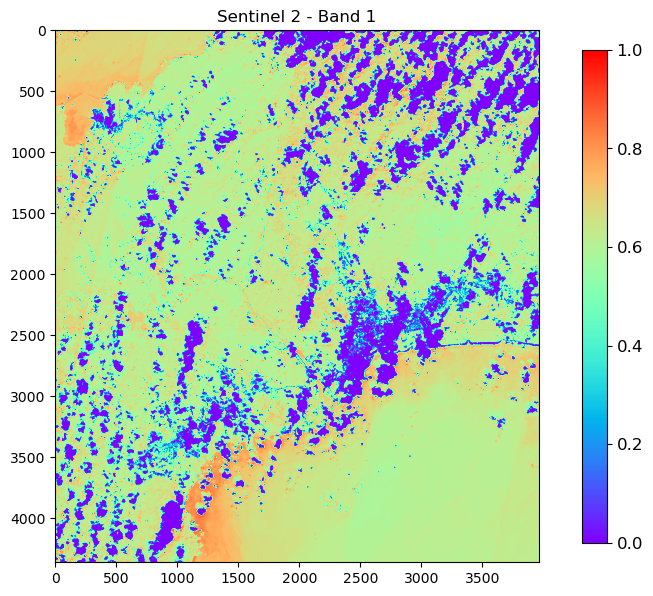

In [11]:
if FIRST_LOCATION_RUN:
    merge_rasters(list_unmerged_rasters, s2_merged_path_no_process)
    reproject_and_clip_raster(s2_merged_path_no_process, aoi.geometry, s2_merged_path_process)
    
else:
    s2_data, s2_profile = open_tif_file(s2_merged_path_process)
    
    s2_data_processed = np.zeros(s2_data.shape)
    for band in range(s2_data.shape[0]):
        vmin, vmax = np.percentile(s2_data[band], [0, 99]) #- cut top 1 percent for all bands
        temp = np.where(s2_data[band] <= vmax, s2_data[band], 0)
        s2_data_processed[band] = min_max_normalize(temp)


    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(s2_data_processed[0], cmap='rainbow')
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('Sentinel 2 - Band 1')
    plt.show()

## SAR

### Sentinel 1

Interferogram
- double chek the width/height, it seems like its one off

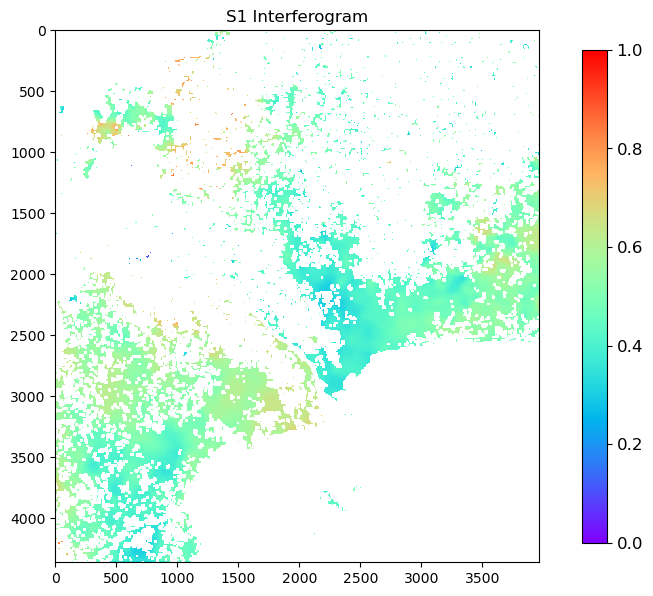

In [12]:
if FIRST_LOCATION_RUN:
    reproject_and_clip_raster(s1_path_no_process, aoi.geometry, s1_path_process)
else:
    s1_interferogram, s1_interferogram_profile = open_tif_file(s1_path_process)
    s1_interferogram = min_max_normalize(s1_interferogram)
    s1_interferogram = np.pad(s1_interferogram, ((0, 0), (0, 1), (0, 0)), mode='constant')[:, :, :3963]

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(s1_interferogram[0], cmap='rainbow')
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('S1 Interferogram')
    plt.show()

### Capella

In [13]:
# with rasterio.open(capella_path) as src:
#     capella = src.read(1)  # Read the first band
#     capella_profile = src.profile

# capella

In [14]:
# capella.mean()

### Iceye

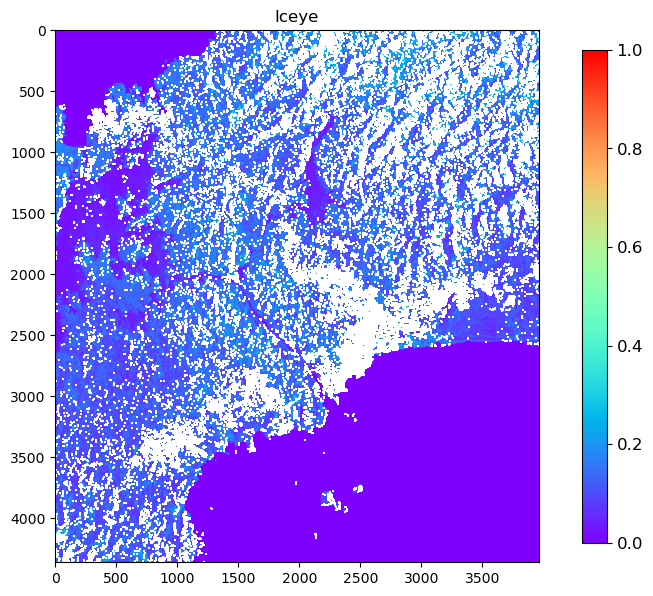

In [15]:
if FIRST_LOCATION_RUN:
    reproject_and_clip_raster(iceye_path_no_process, aoi.geometry, iceye_path_process)
else:
    iceye_image, iceye_profile = open_tif_file(iceye_path_process)

    vmin, vmax = np.percentile(iceye_image[0], [0, 99])
    iceye_no_outliers = np.where(iceye_image[0] <= vmax, iceye_image[0], np.nan)
    iceye_no_outliers = min_max_normalize(iceye_no_outliers)

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(iceye_no_outliers, cmap='rainbow')
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('Iceye')
    plt.show()

## Data stacking

In [16]:
combined = np.concatenate((s2_data, s1_interferogram, iceye_image), axis=0)

## Reference Data

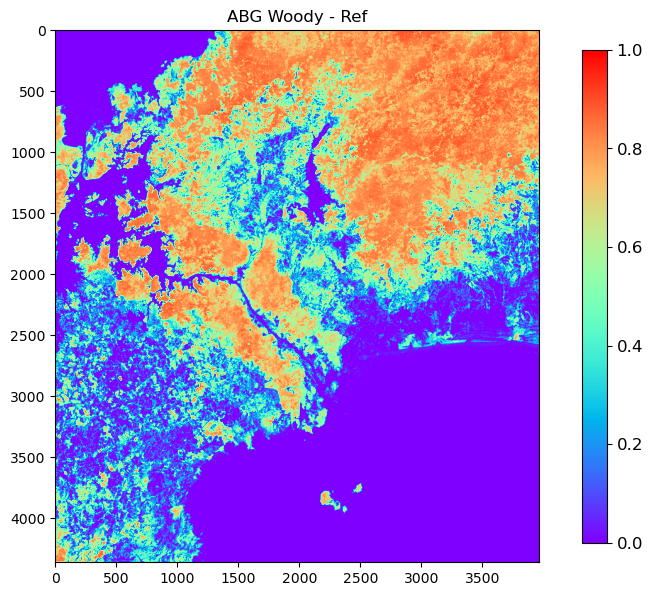

In [18]:
if FIRST_LOCATION_RUN:
    reproject_and_clip_raster('data/Panama/10N_080W.tif', aoi.geometry, 'data/Panama/ref_data_abg_woody.tif')
else:
    ref_data, ref_data_profile = open_tif_file('data/Panama/ref_data_abg_woody.tif')

    ref_no_outliers = np.expand_dims(min_max_normalize(ref_data[0]), axis=0)[:, :, :3963]

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(ref_no_outliers[0], cmap='rainbow')
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('ABG Woody - Ref')
    plt.show()


# Train model

In [ ]:
n_bands, height, width = combined.shape
n_pixels = height * width

## Multiple linear regression

In [ ]:
from sklearn.impute import SimpleImputer

X_flat = combined.reshape(14, -1).T       # (w*h, 14)
y_flat = ref_no_outliers.reshape(-1)             # (w*h, )

# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_flat = imputer.fit_transform(X_flat)

(17278680, 14)
(17278680,)
(17278680, 14)


In [43]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_flat, y_flat)

LinearRegression()

In [44]:
# Predict
y_pred = model.predict(X_flat)

# Compute metrics
mse = mean_squared_error(y_flat, y_pred)
r2 = r2_score(y_flat, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Reshape prediction to original 2D format for visualization or further use
y_pred_image = y_pred.reshape(height, width)

Mean Squared Error: 0.06047555980227664
R² Score: 0.5001384772821663


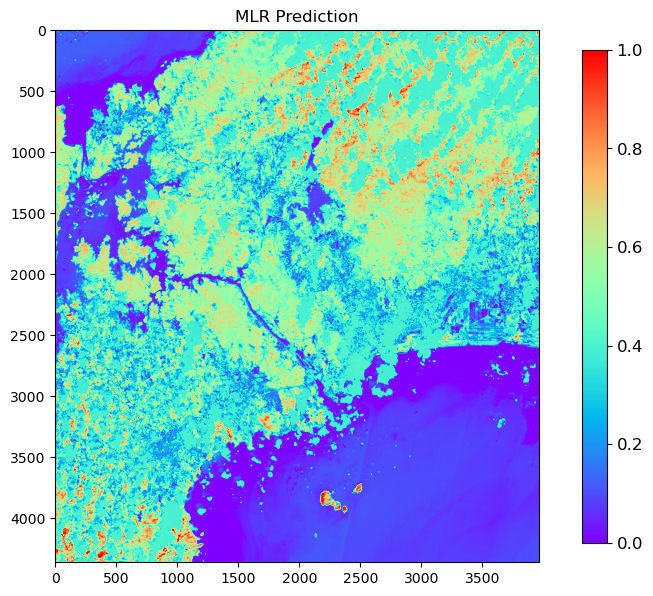

In [45]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(y_pred_image, cmap='rainbow', vmin=0, vmax=1)
cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
cbar.ax.tick_params(labelsize=12)
plt.title('MLR Prediction')
plt.show()

## Random forest

In [ ]:
# Reshape to make the bands last
X_2d = np.transpose(combined, (1, 2, 0)).reshape(n_pixels, n_bands)

y_1d = ref_no_outliers.reshape(n_pixels) # only one band

# Split into test and train 
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y_1d, test_size=0.3, random_state=42
)

In [21]:
# Build random forest model
rf = RandomForestRegressor(
    n_estimators=50,       # fewer trees → faster
    max_depth=15,          # cap tree height → fewer splits
    max_samples=0.25,      # each tree sees only 25% of pixels
    max_features=5,        # at each split, consider 5 of the 8 PCA features
    n_jobs=-1,             # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit on training
rf.fit(X_train, y_train)

# Evaluate on test set
test_score = rf.score(X_test, y_test)
print(f"Test set accuracy: {test_score:.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   19.6s finished


Test set accuracy: 0.7002


In [23]:
# Predict the values
predictions_1d = rf.predict(X_2d)

# Reshape back into the raster
predictions_2d = predictions_1d.reshape(height, width)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.3min finished


In [ ]:
# Vizualize results
# np.save("data/Panama/rf_predictions.npy", predictions_2d)

fig = plt.figure(figsize=(8, 8))
im = plt.imshow(predictions_2d, cmap='rainbow', vmin=0, vmax=1)
cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
cbar.ax.tick_params(labelsize=12)
plt.title('Random Forest Prediction')
plt.show()

## Convolutional neural networks

## Gradient boosted trees